In [116]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.cluster import KMeans

In [27]:
def generate_smiley(points, noise_factor=0.025):
    face_circle = np.array([[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    left_eye = np.array([[0.3 * np.cos(theta) - 0.37, 0.3 * np.sin(theta) + 0.3] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    right_eye = np.array([[0.3 * np.cos(theta) + 0.37, 0.3 * np.sin(theta) + 0.3] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    smile = np.array([[0.8 * np.cos(theta), 0.4 * np.sin(theta) - 0.7] for theta in np.linspace(0.4 * np.pi, 0.6 * np.pi, points)])
    
    # Add noise to the coordinates
    noise = np.random.normal(scale=noise_factor, size=(len(face_circle), 2))
    face_circle += noise
    noise = np.random.normal(scale=noise_factor, size=(len(left_eye), 2))
    left_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(right_eye), 2))
    right_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(smile), 2))
    smile += noise
    
    return np.concatenate([face_circle, left_eye, right_eye, smile])

In [132]:
def plot_points(points):
    #plt.figure(figsize=(6, 6))
    plt.scatter(points[:, 0], points[:, 1], s=5, c='blue')
    plt.title('Point dataset')
    plt.show()

def delaunay_triangulation(points):
    tri = Delaunay(points)
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    #plt.plot(points[:,0], points[:,1], 'o')
    plt.title('Delaunay Graph')
    plt.show()

def rdg_compute(points):
    # Create a Delaunay triangulation
    tri = Delaunay(points)
    result_edge_map = {}

    # Calculate minimum distances between each point and its neighbors
    for i, point in enumerate(points):
        # Find the indices of neighboring vertices for the current point
        simplex_indices = np.where(np.any(tri.simplices == i, axis=1))[0]
        neighbor_indices = np.unique(tri.simplices[simplex_indices])
        neighbors = points[neighbor_indices]

        distances = np.linalg.norm(neighbors - point, axis=1)
        min_distance = np.min(distances[distances > 0])  # Avoid zero distances

        # Calculate distances between neighboring vertices
        for neighbor, distance in zip(neighbors, distances):
            if distance > 0:
                ratio = distance / min_distance
                result = np.sqrt(ratio * (distance / min_distance))  # Geometric average of ratios
                edge = tuple(sorted((tuple(point), tuple(neighbor)), key=lambda x: (x[0], x[1])))
                result_edge_map[edge] = result

    '''
    Attempt at calculating a dynamic threshold for the results as the average of all of them
    total_sum = 0
    count = 0
    for value in result_edge_map.values():
        if isinstance(value, (int, float)):
            total_sum += value
            count += 1
    #if count == 0:
     #   return 0  # To avoid division by zero
    threshold = total_sum / count
    print(f"Dynamic computed threshold: {threshold}")
    '''
    threshold = 1.65
    result_edge_map = {key: value for key, value in result_edge_map.items() if not (isinstance(value, (int, float)) and value >= threshold)}
    
    for edge, result in result_edge_map.items():
        #print(f"Edge: {edge} -> Result: {result}")
        edge_array = np.array(edge)
        plt.plot(edge_array[:, 0], edge_array[:, 1], color='blue')

    # Plot the original points
    #plt.scatter(points[:, 0], points[:, 1], color='blue')
    plt.title('Reduced Delaunay Graph')
    plt.show()

def kmeans_clustering(points, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(points)

    # Create a mesh grid to plot the decision boundaries
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    # Predict clusters for each point in the mesh grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, s=25, cmap='viridis', edgecolors='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=10, alpha=0.9, marker='X')
    plt.title('K-means Clustering')
    plt.show()

def reduced_delaunay_graph(points, threshold):
    """
    Calculate a reduced Delaunay graph based on a given threshold.

    Parameters:
    - points: 2D array-like, shape (n, 2)
        The input points for Delaunay triangulation.
    - threshold: float
        The threshold for excluding edges that are too long.

    Returns:
    - edges: list of tuples
        The reduced Delaunay graph edges.
    - edge_ratios: dict
        A dictionary associating each edge with its geometric average ratio.
    """

    # Perform Delaunay triangulation
    tri = Delaunay(points)

    # Get the vertices and simplices of the Delaunay triangulation
    vertices = tri.points
    simplices = tri.simplices

    edge_ratios = {}  # Store geometric average ratios for each edge

    # Helper function to calculate the distance between two points
    def distance(p1, p2):
        return np.linalg.norm(p1 - p2)

    # Iterate over all simplices (triangles)
    for simplex in simplices:
        for i in range(3):
            # Get the current vertex
            vertex_a = simplex[i]

            for j in range(i + 1, 3):
                # Get the neighboring vertex
                vertex_b = simplex[j]

                # Ensure that the edge is not processed twice
                if (vertex_a, vertex_b) not in edge_ratios and (vertex_b, vertex_a) not in edge_ratios:
                    # Calculate distance and ratio for both vertices
                    dist_a_b = distance(vertices[vertex_a], vertices[vertex_b])
                    dist_a_neighbors = [distance(vertices[vertex_a], vertices[neighbor]) for neighbor in simplex if neighbor != vertex_b]
                    dist_b_neighbors = [distance(vertices[vertex_b], vertices[neighbor]) for neighbor in simplex if neighbor != vertex_a]

                    # Calculate the geometric average ratio
                    ratio_a = dist_a_b / np.min(dist_a_neighbors)
                    ratio_b = dist_a_b / np.min(dist_b_neighbors)
                    geometric_avg_ratio = np.sqrt(ratio_a * ratio_b)

                    # Check if the geometric average ratio is below the threshold
                    if geometric_avg_ratio > threshold:
                        edge_ratios[(vertex_a, vertex_b)] = geometric_avg_ratio

    print(edge_ratios)
    for edge, result in edge_ratios.items():
        #print(f"Edge: {edge} -> Result: {result}")
        edge_array = np.array(edge)
        plt.plot(edge_array[:, 0], edge_array[:, 1], color='blue')

    # Plot the original points
    #plt.scatter(points[:, 0], points[:, 1], color='blue')
    plt.title('Reduced Delaunay Graph')
    plt.show()

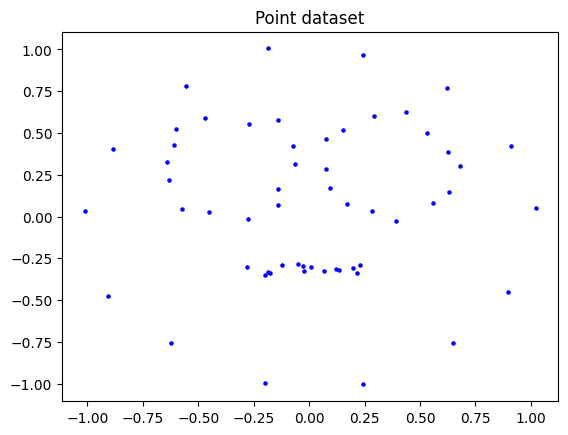

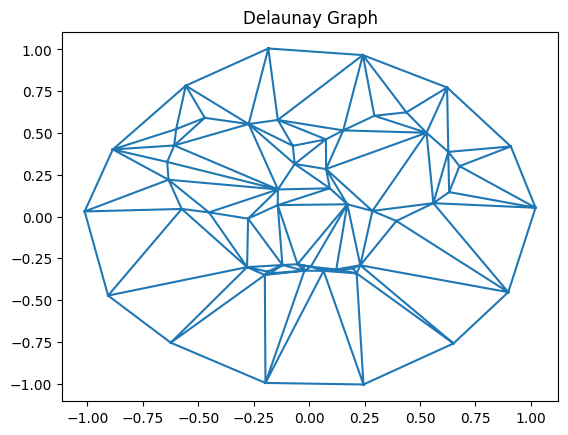

{(10, 54): inf, (10, 9): inf, (54, 9): inf, (12, 13): inf, (12, 42): inf, (13, 42): inf, (8, 23): inf, (8, 7): inf, (23, 7): inf, (4, 16): inf, (4, 3): inf, (16, 3): inf, (52, 51): inf, (52, 26): inf, (51, 26): inf, (12, 43): inf, (12, 11): inf, (43, 11): inf, (43, 42): inf, (32, 33): inf, (32, 30): inf, (33, 30): inf, (33, 16): inf, (33, 34): inf, (16, 34): inf, (33, 3): inf, (32, 3): inf, (2, 31): inf, (2, 30): inf, (31, 30): inf, (31, 32): inf, (31, 3): inf, (2, 3): inf, (17, 4): inf, (17, 5): inf, (4, 5): inf, (17, 16): inf, (56, 8): inf, (56, 9): inf, (8, 9): inf, (54, 56): inf, (56, 23): inf, (56, 24): inf, (24, 23): inf, (24, 22): inf, (22, 23): inf, (22, 7): inf, (22, 6): inf, (6, 7): inf, (6, 21): inf, (22, 21): inf, (35, 33): inf, (35, 34): inf, (35, 38): inf, (35, 30): inf, (38, 30): inf, (18, 17): inf, (18, 5): inf, (1, 28): inf, (1, 0): inf, (28, 0): inf, (28, 41): inf, (41, 0): inf, (38, 40): inf, (40, 30): inf, (40, 13): inf, (40, 0): inf, (13, 0): inf, (41, 40): inf, (5

C:\Users\Teo\AppData\Local\Temp\ipykernel_13820\4130212606.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  ratio_a = dist_a_b / np.min(dist_a_neighbors)
C:\Users\Teo\AppData\Local\Temp\ipykernel_13820\4130212606.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  ratio_b = dist_a_b / np.min(dist_b_neighbors)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [133]:
# Example array of points
#points = np.array([[-1, -1], [-1, -0.75], [-0.75, -0.75], [-0.75, -1], [1, 1], [1, 0.75], [0.75, 0.75], [0.75, 1], [-1, 1], [-1, 0.75], [-0.75, 0.75], [-0.75, 1], [1, -1], [1, -0.75], [0.75, -0.75], [0.75, -1]])
points = generate_smiley(15)

plot_points(points)
delaunay_triangulation(points)
#rdg_compute(points)
threshold = 1.65
reduced_delaunay_graph(points, threshold)
kmeans_clustering(points, 4)